In [ ]:
!pip install pyspark

In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType, FloatType
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.express as px
from pyspark.sql import functions as F

In [ ]:
spark = SparkSession.builder \
    .appName("Sentiment Analysis") \
    .getOrCreate()


In [ ]:
df = spark.read.csv("realdonaldtrump.csv", header=True, inferSchema=True)

In [ ]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

In [ ]:
clean_text_udf = udf(clean_text, StringType())
df = df.withColumn("clean_content", clean_text_udf(col("content")))

In [ ]:
def analyze_sentiment(text):
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    import nltk
    nltk.download('vader_lexicon')
    sid = SentimentIntensityAnalyzer()
    sentiment_score = sid.polarity_scores(text)["compound"]
    if sentiment_score >= 0.05:
        return "Positive"
    elif sentiment_score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

In [ ]:
analyze_sentiment_udf = udf(analyze_sentiment, StringType())
df = df.withColumn("sentiment", analyze_sentiment_udf(col("clean_content")))

In [ ]:
indexer = StringIndexer(inputCol="sentiment", outputCol="label")
df = indexer.fit(df).transform(df)

In [ ]:
(training, testing) = df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
tokenizer = Tokenizer(inputCol="clean_content", outputCol="words")
remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="filtered_words")
hashingTF = HashingTF(inputCol=remover.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.01, labelCol="label")
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, lr])

In [ ]:
model = pipeline.fit(training)

In [ ]:
predictions = model.transform(testing)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator.evaluate(predictions)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator.evaluate(predictions)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1 = evaluator.evaluate(predictions)

In [ ]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.7674337517433751
Precision: 0.7651446616004491
Recall: 0.7674337517433751
F1-score: 0.765997491405102


In [ ]:
classified_data = model.transform(df)

In [ ]:
sentiment_distribution = classified_data.groupBy("sentiment").count().collect()

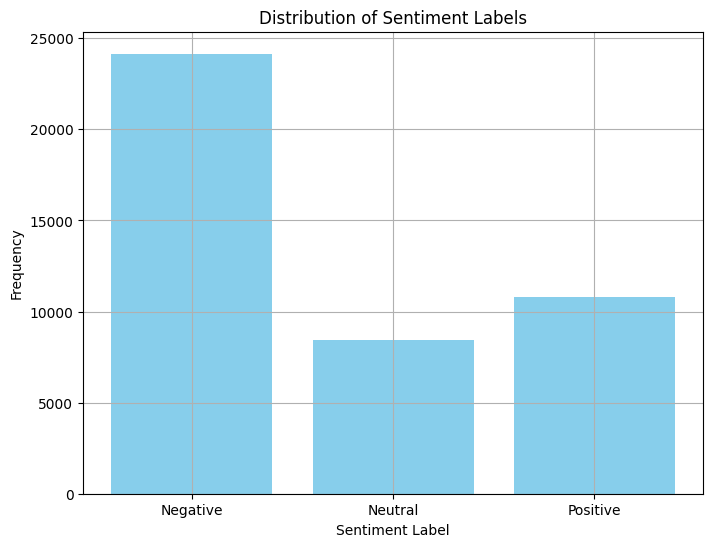

In [ ]:
labels = ["Negative", "Neutral", "Positive"]
counts = [row["count"] for row in sentiment_distribution]
plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color='skyblue')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment Label')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

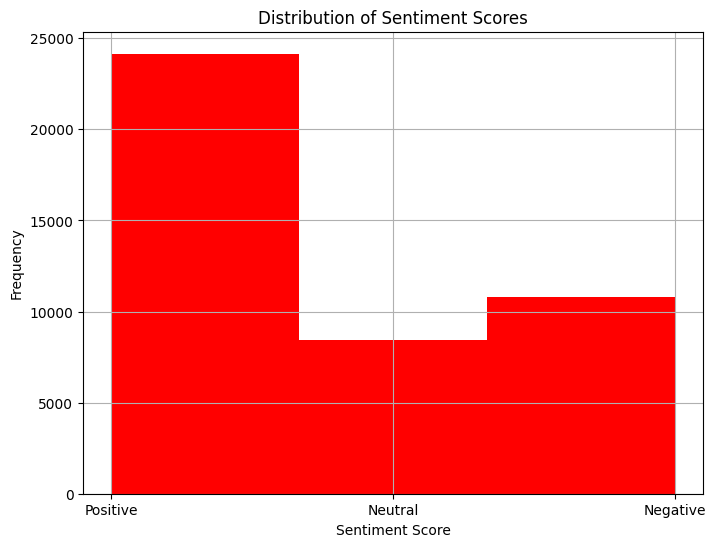

In [ ]:
sentiment_scores = classified_data.select("sentiment").collect()
sentiment_scores = [row["sentiment"] for row in sentiment_scores]
plt.figure(figsize=(8, 6))
plt.hist(sentiment_scores, bins=3, color='red')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

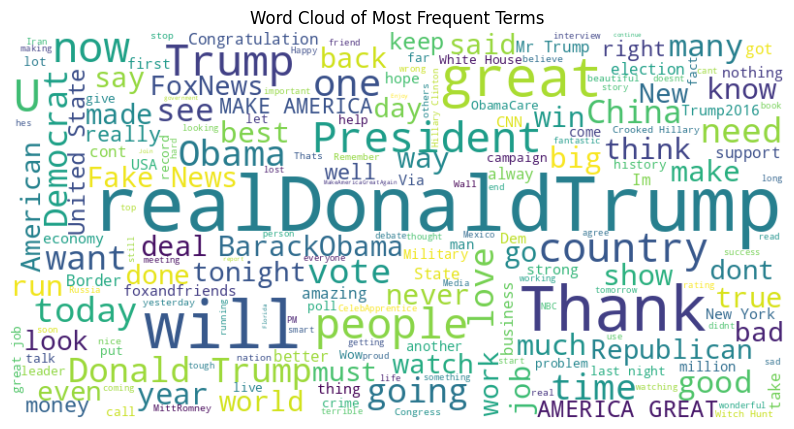

In [ ]:
text = " ".join(classified_data.select("clean_content").rdd.flatMap(lambda x: x).collect())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Terms')
plt.show()

In [ ]:
print(df.head())

Row(id=1698308935, link='https://twitter.com/realDonaldTrump/status/1698308935', content='Be sure to tune in and watch Donald Trump on Late Night with David Letterman as he presents the Top Ten List tonight!', date='2009-05-04 13:54:25', retweets='510', favorites='917', mentions=None, hashtags=None, clean_content='Be sure to tune in and watch Donald Trump on Late Night with David Letterman as he presents the Top Ten List tonight', sentiment='Positive', label=0.0)


In [ ]:
print(classified_data.head())

Row(id=1698308935, link='https://twitter.com/realDonaldTrump/status/1698308935', content='Be sure to tune in and watch Donald Trump on Late Night with David Letterman as he presents the Top Ten List tonight!', date=None, retweets='510', favorites='917', mentions=None, hashtags=None, clean_content='Be sure to tune in and watch Donald Trump on Late Night with David Letterman as he presents the Top Ten List tonight', sentiment='Positive', label=0.0, words=['be', 'sure', 'to', 'tune', 'in', 'and', 'watch', 'donald', 'trump', 'on', 'late', 'night', 'with', 'david', 'letterman', 'as', 'he', 'presents', 'the', 'top', 'ten', 'list', 'tonight'], filtered_words=['sure', 'tune', 'watch', 'donald', 'trump', 'late', 'night', 'david', 'letterman', 'presents', 'top', 'ten', 'list', 'tonight'], features=SparseVector(262144, {14376: 1.0, 18176: 1.0, 64382: 1.0, 68727: 1.0, 73853: 1.0, 93376: 1.0, 94950: 1.0, 120768: 1.0, 134125: 1.0, 153917: 1.0, 155613: 1.0, 173018: 1.0, 189957: 1.0, 229604: 1.0}), ra

In [ ]:
filtered_data = df.filter(col("date").isNotNull())
tweet_volume = filtered_data.groupBy("date").count().collect()
dates = [row["date"] for row in tweet_volume]
counts = [row["count"] for row in tweet_volume]
fig = px.line(x=dates, y=counts, title='Tweet Volume Over Time')
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Tweet Count')
fig.show()

In [ ]:
spark.stop()
